# Ridge Regression with Scikit-Learn

### NOTE:  if you are viewing this notebook on github and the LaTeX equations are not rendering properly, please try viewing this notebook instead using nbviewer at:  http://nbviewer.jupyter.org/github/dpshenoy/ml_examples/blob/master/RidgeRegression.ipynb?flush_cache=true 

### This example elaborates on:  http://scikit-learn.org/stable/modules/linear_model.html#ridge-regression 

### In this example I use the diabetes data set to show how RidgeRegression helps mitigate the effect of collinearity in the design matrix $X$.
As in regular linear regression, we model the target values $y_i$ with $\hat{y}_i$ values that are linear combinations of input variables.  For example, if there are 3 features, then: 

$$\hat{y}_i(w,X_{ij}) = w_0 + w_1X_{i0} + w_2X_{i1} + w_3X_{i2}$$

Or in matrix form:

$$
\begin{eqnarray*}
\hat{y} & = & Xw + w_0 \\ \\
\begin{pmatrix} \hat{y}_1 \\ \hat{y}_2 \\ \vdots \end{pmatrix} & = &  \begin{pmatrix} X_{00} & X_{01} & X_{02} \\ X_{10} & X_{11} & X_{12} \\ \vdots & \vdots \end{pmatrix} \begin{pmatrix} w_1 \\ w_2 \\ w_3 \end{pmatrix} + \begin{pmatrix} w_0 \\ w_0 \\ \vdots \end{pmatrix}
\end{eqnarray*}
$$

Linear regression seeks the one vector of coefficients $w$ that minimizes the sum of the squared differences between the linear model $\hat{y}$ and the observed $y$:

$$ \sum_{i=1}^N (y_i - (Xw))^2 $$

Quoting the Scikit-learn page linked above:  

"[C]oefficient estimates for Ordinary Least Squares rely on the independence of the model terms. When terms are correlated and the columns of the design matrix $X$ have an approximate linear dependence, the design matrix becomes close to singular and as a result, the least-squares estimate becomes highly sensitive to random errors in the observed response, producing a large variance. This situation of multicollinearity can arise, for example, when data are collected without an experimental design."

To address this problem, RidgeRegression adds a "shrinkage" parameter $\alpha$ to the minimization:

$$ \sum_{i=1}^N (y_i - (Xw))^2 + \alpha\sum_{j=1}^p w_j^2 $$

As $\alpha$ is increased, the sizes of the $w_j$ decrease; this can suppress the problem of collinearity in matrix $X$.  This example will have 3 features ($p$ = 3), with two of the features purposely rigged to be highly correlated.  Thus two of the columns of $X$ will be approximately collinear, allowing the effect of varying $\alpha$ to be observed.

In [1]:
import pandas as pd ; import numpy as np ; import random ; from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

## $\S$ 1 - Read in the example data

In [2]:
# Read in the NC State diabetes data set.  This is the same one available from
# sklearn.datasets.load_diabetes(), but I prefer to get it from the original page
# linked in the sklearn docs:  http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html
# Using that instead, when I read it into a Pandas DataFrame, I get column headings.
df = pd.read_table('diabetes.rwrite1.txt',delimiter=' ')
df.shape

(442, 11)

In [3]:
df.head(3)

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu,y
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141


(array([  1.,   4.,   7.,   9.,  20.,  28.,  42.,  40.,  57.,  54.,  38.,
         41.,  32.,  21.,  14.,  14.,   8.,   3.,   4.,   3.,   2.]),
 array([-0.12678067, -0.11341427, -0.10004787, -0.08668147, -0.07331507,
        -0.05994867, -0.04658227, -0.03321588, -0.01984948, -0.00648308,
         0.00688332,  0.02024972,  0.03361612,  0.04698252,  0.06034892,
         0.07371532,  0.08708172,  0.10044812,  0.11381452,  0.12718091,
         0.14054731,  0.15391371]),
 <a list of 21 Patch objects>)

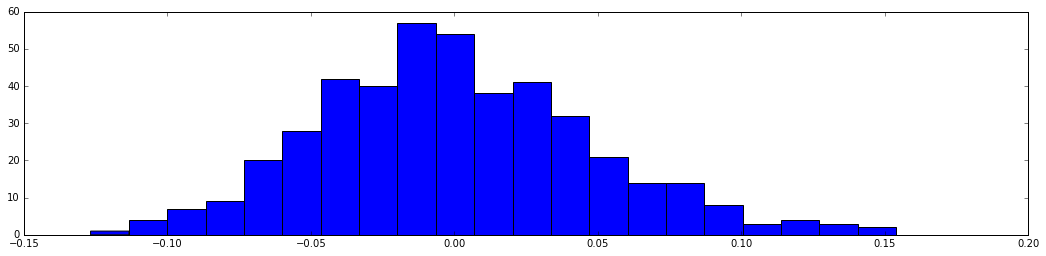

In [4]:
# Note that the data have been normalized so that for each column the mean is zero and the
# length is 1.  (If you want to manually normalize the original data yourself, go to  
# http://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt to get the original data.
# For each column, subtract its mean and then divide each column by its length (i.e., sqrt 
# of the sum of its squared values).  That produces the normalized values shown above.

# Here's a quick little histogram of one column, to illustrate the normalization
plt.rcParams["figure.figsize"] = (18,4)
plt.hist(df.tc,bins=21)

In [5]:
# declare a function for plotting a correlation matrix for a Pandas DataFrame
def plot_corr(df, size):
    """
    Plots correlation matrix for each pair of columns.
    Blue-to-red runs from not-corr (or 0) to correlated (or 1)
    """
    corr = df.corr()
    fig, ax = plt.subplots(figsize = (size,size))
    cax = ax.matshow(corr,cmap='seismic')
    fig.colorbar(cax,fraction=0.0458, pad=0.04)
    plt.xticks(np.arange(len(corr.columns)), corr.columns)
    plt.yticks(np.arange(len(corr.columns)), corr.columns)

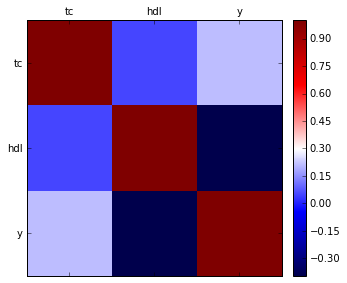

In [6]:
# after some playing around, I choose to use columns tc and hdl since 
# they are one of the least correlated pairings of features.  
# Here's a plot for features tc and hdl (and the target y).
plot_corr(df[['tc','hdl','y']],5)

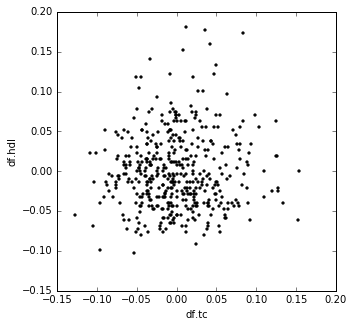

In [7]:
# also, make a scatter plot of tc and hdl against each other, 
# which is another way to assess correlation more visually.
def scat_corr(ax,feat1,feat2,lab1,lab2,col):
    '''
    Scatter plots feat1 against feat1 for 
    visually assessing correlation
    '''
    ax.scatter(feat1,feat2,color=col,s=5)
    ax.set_xlabel(lab1)
    ax.set_ylabel(lab2)

plt.rcParams["figure.figsize"] = (5,5)
fig, ax1 = plt.subplots()
scat_corr(ax1,df.tc,df.hdl,'df.tc','df.hdl','k')

In [8]:
# get rid of all columns other than tc, hdl and y
for col in ['age', 'sex', 'bmi', 'map', 'ldl', 'tch', 'ltg', 'glu']:  del df[col]
df.head(5)

,tc,hdl,y
0,-0.044223,-0.043401,151
1,-0.008449,0.074412,75
2,-0.045599,-0.032356,141
3,0.012191,-0.036038,206
4,0.003935,0.008142,135


## $\S$ 2 - Collinearity:  Artifically add a correlated feature.
###  Pretend we had bad experimental design:  We recorded another blood serum measurement called "zdl".  It turns out that "zdl" measures the same quantity measured by an hdl measurement, with the only difference being that zdl is reported in different units.  Pretend the measurement of zdl is done using somewhat different chemistry or equipment.  Therefore rescaling the zdl measurement into hdl units won't reproduce the *exact* same hdl value that was measured for a patient.  So the correlation between our recorded hdl and zdl values is not completely 100%, but it is very high.  Therefore the assumption of independence of the features needed for regular linear regression is violated.

In [9]:
# Since the hdl measurements are already normalized, it doesn't matter what the scaling 
# factor between hdl and "zdl" is.  Instead, I just fake "zdl" measurements by adding 
# some pseudorandom noise onto the already normalized hdl values.
np.random.seed(datetime.now().microsecond)
df['zdl'] = df['hdl'] + np.random.uniform(-0.005, 0.005, len(df.tc))

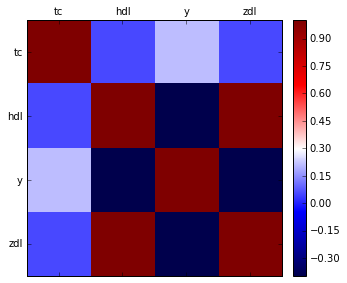

In [10]:
# Show that hdl and zdl are highly correlated
plot_corr(df,5)

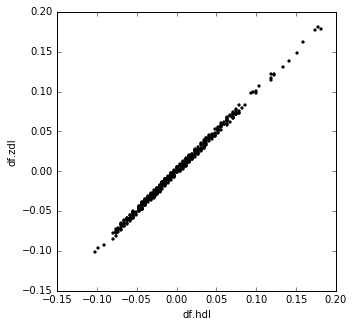

In [11]:
# and also show the correlation with a scatter plot
plt.rcParams["figure.figsize"] = (5,5)
fig, ax1 = plt.subplots(1,1)
scat_corr(ax1,df.hdl,df.zdl,'df.hdl','df.zdl','k')

In [12]:
# for ease of reading below, form matrix X-- each column is one feature
X = df[ ['tc','hdl','zdl'] ].values
X.shape

(442, 3)

In [13]:
# form vector y of the target
y = df['y'].values
y.shape

(442,)

In [14]:
# a peek at the first few rows to compare to the data frame
X[:5], y[:5]

(array([[-0.0442235 , -0.04340085, -0.04560615],
        [-0.00844872,  0.07441156,  0.07412918],
        [-0.04559945, -0.03235593, -0.02856387],
        [ 0.01219057, -0.03603757, -0.03644626],
        [ 0.00393485,  0.00814208,  0.01223068]]),
 array([151,  75, 141, 206, 135]))

## $\S$ 3 - Using Ridge Regression 

In the matrix $X$ depicted earlier, $X_{i1}$ is the column vector of tc values, $X_{i2}$ is the column vector of hdl values, and $X_{i3}$ is the column vector of zdl values.  Play with the size of $\alpha$ to find a "sweet spot" that mitigates the problem of collinearity of columns $X_{i2}$ and $X_{i3}$ without having much effect on the uncorrelated feature tc (column $X_{i0}$).  In other words, look for a value of $\alpha$ that tamps down wide variation between $w_2$ and $w_3$ without also dragging down $w_1$ excessively.

In [15]:
# fit RidgeRegression models for a range of alpha values
from sklearn import linear_model
n_alphas = 20
alphas = np.logspace(-4, 0, n_alphas)
clf = linear_model.Ridge()

coefs = []
for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(X, y)
    coefs.append(clf.coef_)

In [16]:
# make an array of each feature's weight for plotting & labeling
w1 = np.array(coefs)[:,0]
w2 = np.array(coefs)[:,1]
w3 = np.array(coefs)[:,2]

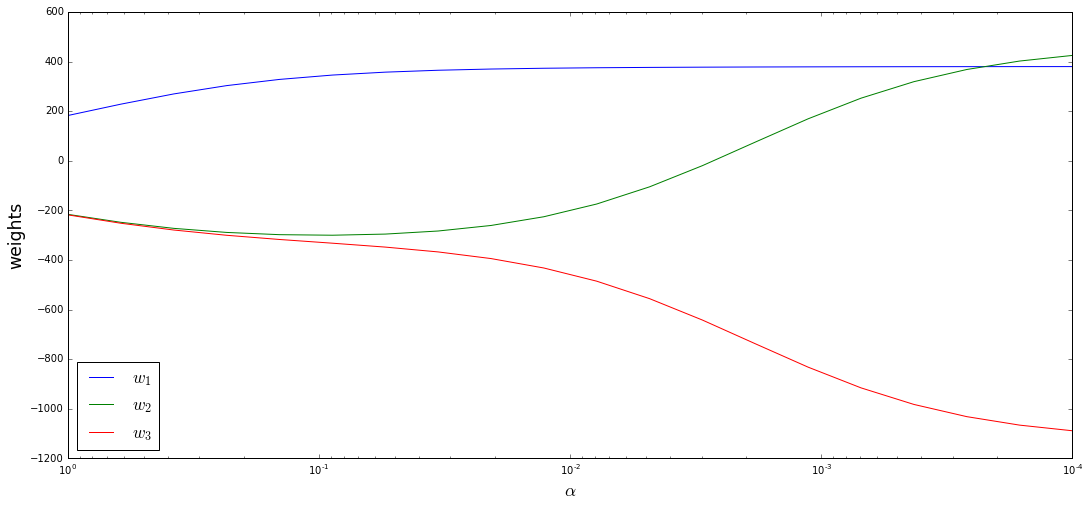

In [17]:
# plot each weight versus alpha
plt.rcParams["figure.figsize"] = (18,8)

plt.plot(alphas, w1, label=r'$w_1$')
plt.plot(alphas, w2, label=r'$w_2$')
plt.plot(alphas, w3, label=r'$w_3$')

plt.xscale('log')
plt.xlim(plt.xlim()[::-1])  # reverse axis
plt.xlabel(r'$\alpha$',fontsize='xx-large')
plt.ylabel('weights',fontsize='xx-large')
plt.legend(fontsize='xx-large',loc='lower left')

### A value of $\alpha$ $\sim$ 0.01 reduces the large discrepancy between $w_2$ and $w_3$ without much effect on $w_1$ (the weight for tc, which is independent of hdl and zdl).